In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

In [20]:
#declaring predefined variables

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [40]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Testing",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)
    

Found 68 files belonging to 2 classes.


In [41]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Training and Validation",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 1832 files belonging to 2 classes.


In [22]:
#our classes i.e. 2 different tomato leaf diseases
class_names = dataset.class_names
class_names

['fire', 'nofire']

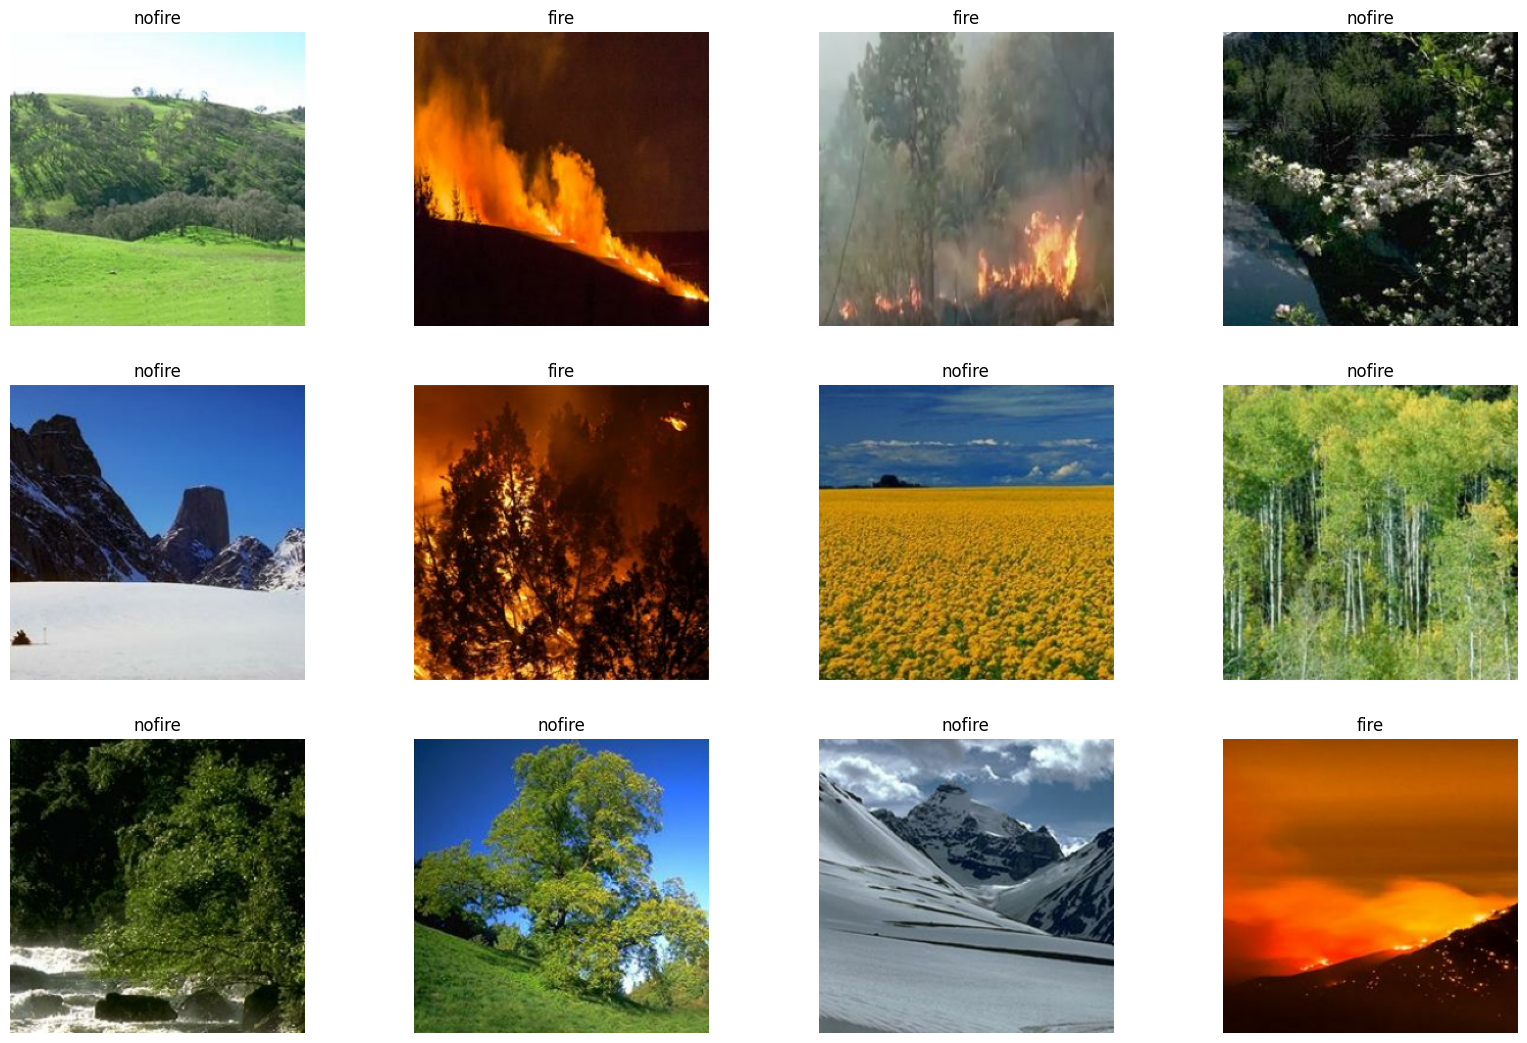

In [23]:
plt.figure(figsize=(20,13))

for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [24]:
len(dataset)

58

In [25]:
#function to split data into train and validation in the ratio of 80:10:10 respectively

def get_dataset_partitions_tf(ds, train_split=0.70, val_split=0.30,shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [26]:
train_ds, val_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

40

In [28]:
len(val_ds)

17

In [29]:
#cache and prefetch to improve perfomance and reduce training time

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
#we resize the images to be of size 256 by 256
#then, we normalize the features by dividing it by 255

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [31]:
#augment the data to generate more data from a single picture e.g. same feature(image) when twisted horizontally or vertically
#when the feature(image) is rotated at some angle

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
# map training set to above data_augmentation to augment trainig set

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
#shape of input features

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [34]:
#summary of our model

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [36]:
model = tf.keras.models.load_model("../models/model.h5")

first image to predict
actual label: nofire
1/1 [==============================] - 0s 394ms/step
predicted label: nofire


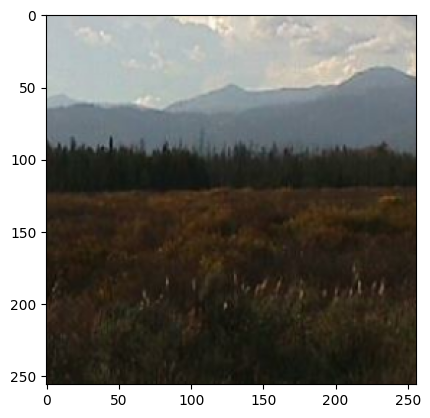

In [43]:
for images_batch, labels_batch in test_data.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)# Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 159ms/step


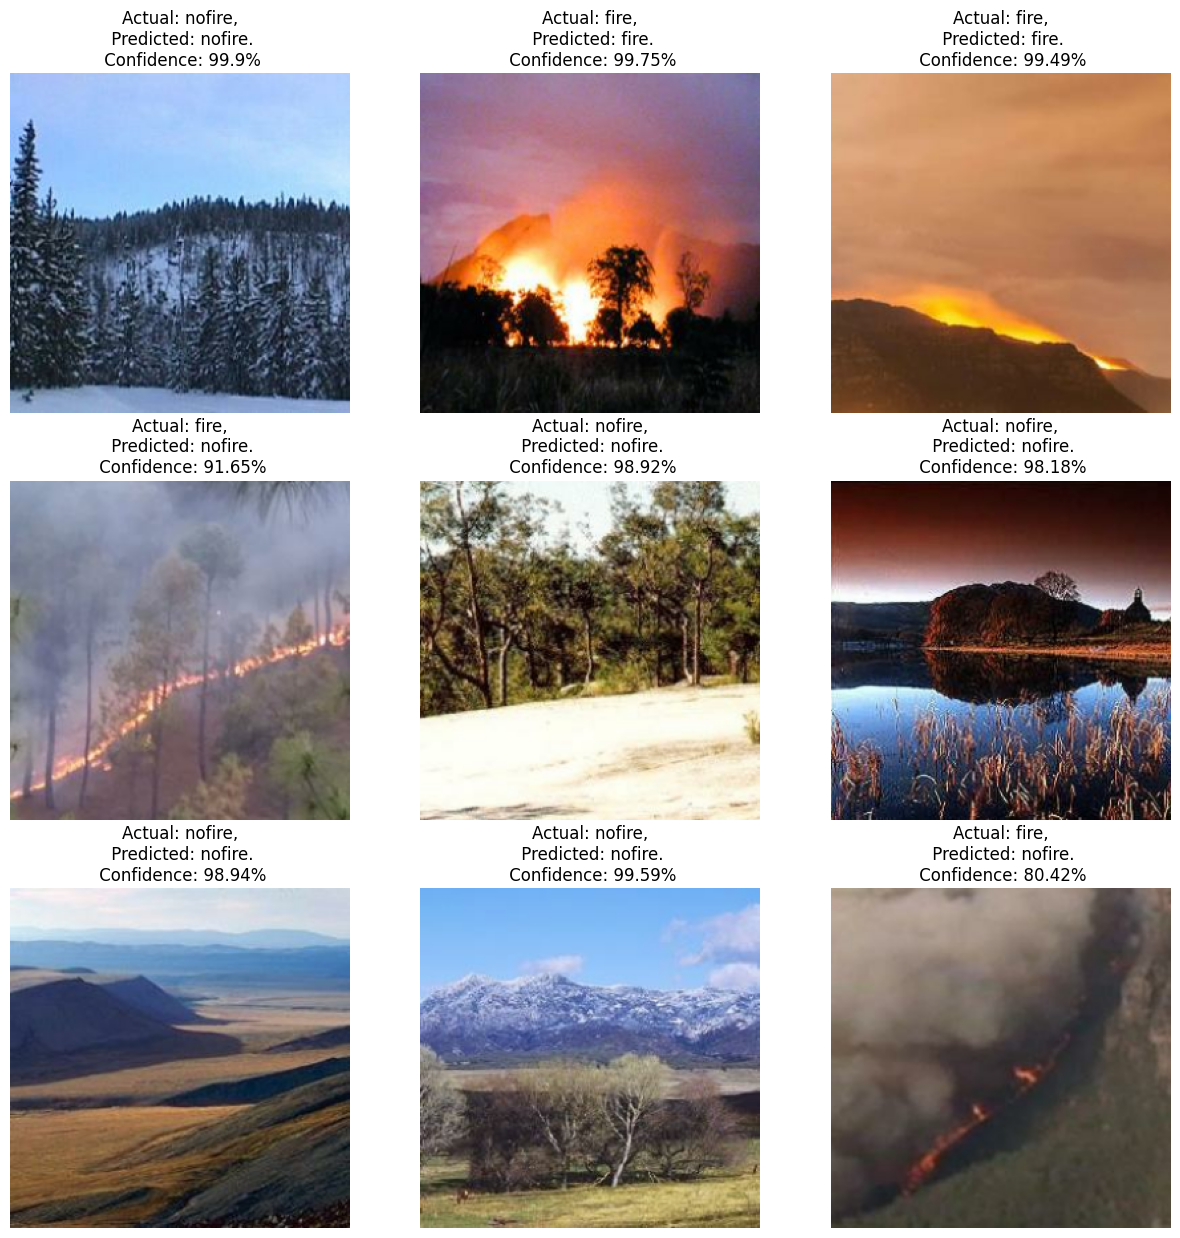

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
scores = model.evaluate(test_data)

3/3 [==============================] - 1s 208ms/step - loss: 0.2385 - accuracy: 0.8971


In [63]:
scores

[0.23848864436149597, 0.8970588445663452]